# Шкарбаненко Михаил, Б05-907

# Задача 4. Вариационный автокодировщик

Провести синтетический эксперимент с моделью вариационного автокодировщика в случае, если данные не из бернуливского распределения, а из нормального. В качестве данных использовать синтетическую выборку, которая состоит из нескольких кластеров в виде гаусиан (каждый кластер является множеством векторов из нормального распределения с парметрами mu, Sigma). В рамках эксперимента требуется исследовать:

* зависимость качества востановления от размера скрытого представления;
* зависимость качества востановления от размера исходного пространства;
* зависимость качества востановления от отношения размера скрытого представления к исходном;
* зависимость качества востановления от сложности модели нейросети.
* Все выводы должны быть представленны в формате tensorboard (каждый набор параметров, свой график, пример --- второй семинар).

P.S. в рамках семинара мы востанавливали параметры бернуливского распределения, так как изображение это числа от 0 до 1 --- вероятности бернуливской случайной величины. Теперь требуется, чтобы модель decoder востанаввливала параметры нормального случайного вектора.

P.S.S. в качестве модели encoder и decoder можно выбирать любую архитектуру нейросети.

## 1. Подготовительная часть

### 1.1 Библиотеки

In [147]:
from copy import deepcopy
import matplotlib.pyplot as plt
import io
import os
from urllib.request import urlopen

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy.stats import norm
import torch

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence

from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from sklearn.model_selection import ParameterGrid
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

### 1.2 Девайс

In [148]:
device = torch.device("cpu")

### 1.3 Датасет

In [149]:
def generate_data(cluster_size, dim, num_clusters=5):
    X, mu, sigma = [], [], []
    for _ in range(num_clusters):
        mean = np.random.uniform(-4, 4, dim)
        cov = np.random.uniform(1, 2, dim)
        cluster = np.random.multivariate_normal(mean=mean, cov=np.diag(cov), size=cluster_size)
        X.append(cluster)
        mu.append(mean)
        sigma.append(cov)
    X = np.stack(X).reshape(-1, dim)
    return X, mu, sigma

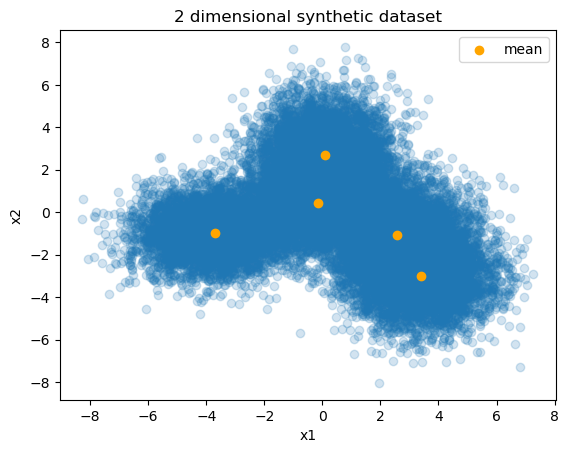

In [150]:
cluster_size, dim, num_clusters = 5000, 2, 5
X, mus, sigmas = generate_data(cluster_size, dim, num_clusters)
x, y = X.T
plt.scatter(x, y, alpha=0.2)
for i, mu in enumerate(mus):
    if i == 0:
        plt.scatter(mu[0], mu[1], c='orange', marker='o', label="mean")
    else:
        plt.scatter(mu[0], mu[1], c='orange', marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2 dimensional synthetic dataset')
plt.legend()
plt.show()

### 1.4 Модель

In [151]:
class VAE(nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
    def __init__(self,
                 in_channels,
                 latent_dim,
                 n_layers):
        super().__init__()

        self.latent_dim = latent_dim

        modules = []       
        hidden_dims = [10 * 2**i for i in range( n_layers)]
        
        tmp = in_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(tmp, h_dim), 
                    nn.BatchNorm1d(h_dim), 
                    nn.LeakyReLU())
            )
            tmp = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.Linear(hidden_dims[-1], hidden_dims[-1]),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1], in_channels))

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss(self, *args, **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss =F.mse_loss(recons, input) 
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_loss
        return loss 

    def sample(self,
               num_samples:int, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(self.device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

### 1.5 Логгер

In [152]:
class Callback():

    def __init__(self, writer, test_dataloader, loss_function, delimeter=100):

        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.test_dataloader = test_dataloader

    def forward(self, model, loss):

        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            pred = []
            real = []
            test_loss = 0
            total_num = 0
            
            model.eval()
            with torch.no_grad():
                for x_batch in self.test_dataloader:
                    x_batch = x_batch[0].to(device)
                    y_batch = x_batch
                    output = model(x_batch)
                    test_loss += self.loss_function(*output).cpu().item() \
                                 * len(x_batch)
                    total_num += len(x_batch)
              
                    pred.extend(output[0].cpu().numpy())
                    real.extend(y_batch.cpu().numpy())
                    
            test_loss /= total_num
            score = "R2 score: {}".format(r2_score(pred, real))
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            self.writer.add_text('REPORT/test', score, self.step)
          
    def __call__(self, model, loss):
        
        return self.forward(model, loss)

### 1.6 Обучение

In [153]:
def trainer(count_of_epoch, 
            batch_size, 
            train_dataset,
            test_dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            writer = None,
            callback = None
           ):

    optima = optimizer(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optima, gamma=0.9)
    
    for it in range(count_of_epoch):

        train_generator = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_generator = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

        
        epoch_loss = train_epoch(train_generator=train_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima,
                    scheduler=scheduler,
                    writer=writer,
                    epoch=it,
                    callback=callback)
        
def train_on_batch(model, x_batch, optimizer, loss_function):

    model.train()
    optimizer.zero_grad()
    
    results = model(x_batch.to(model.device))
    loss = model.loss(*results)
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

def train_epoch(train_generator, model, loss_function, optimizer, scheduler=None, writer=None, epoch=None, callback=None):
    
    epoch_loss = 0
    total = 0
    step = len(train_generator) * epoch
    loop = tqdm(train_generator)
    for batch_of_x in loop:
        batch_loss = train_on_batch(model, batch_of_x[0], optimizer, loss_function)
        if callback:
            callback(model, batch_loss)
        loss = batch_loss*len(batch_of_x)
        writer.add_scalar('LOSS/train', loss, step)
        epoch_loss += loss
        total += len(batch_of_x)
        loop.set_description(f'{epoch}. Loss: {loss:.4f}')
        step += 1
    scheduler.step()
    
    return epoch_loss/total

## 2. Эксперименты

In [154]:
grid = ParameterGrid({
    'latent_dim': [8, 16], 
    'input_dim': [2, 8], 
    'n_layers': [2, 4, 8],
})

In [155]:
for item in grid:
    print(str(item))
    X, mus, sigmas = generate_data(cluster_size=3000, dim=item['input_dim'], num_clusters=5)
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X, dtype='float32')))
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X, dtype='float32')))
    
    vae = VAE(
        latent_dim=item['latent_dim'], 
        in_channels=item['input_dim'],
        n_layers=item['n_layers'])
    
    vae.to(device)
    writer = SummaryWriter('logs/' + str(item))
    optimizer = torch.optim.Adam
    test_generator = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
    call = Callback(writer, test_generator, vae.loss)

    trainer(count_of_epoch=5,
              batch_size=64,
              train_dataset=train_dataset,
              test_dataset=test_dataset,
              model=vae, 
              loss_function=vae.loss,
              optimizer = optimizer,
              lr = 0.001,
              writer = writer,
              callback=call)
    
    if item['input_dim'] == 2:
        distr = vae.sample(1000)
        x,y = np.array(distr.detach().cpu()).T
        plt.figure(figsize=(5, 4), dpi=100)
        decoding = vae.generate(distr).detach().cpu()
        plt.scatter(x, y, label='Initial data')
        plt.scatter(decoding[:, 0], decoding[:, 1], label='Generated data')
        plt.axis('equal')
        plt.legend()
        writer.add_figure('Samples', plt.gcf())
        plt.show()

{'input_dim': 2, 'latent_dim': 8, 'n_layers': 2}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 2, 'latent_dim': 8, 'n_layers': 4}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 2, 'latent_dim': 8, 'n_layers': 8}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 2, 'latent_dim': 16, 'n_layers': 2}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 2, 'latent_dim': 16, 'n_layers': 4}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 2, 'latent_dim': 16, 'n_layers': 8}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 8, 'latent_dim': 8, 'n_layers': 2}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 8, 'latent_dim': 8, 'n_layers': 4}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 8, 'latent_dim': 8, 'n_layers': 8}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 8, 'latent_dim': 16, 'n_layers': 2}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 8, 'latent_dim': 16, 'n_layers': 4}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

{'input_dim': 8, 'latent_dim': 16, 'n_layers': 8}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

# 3. Итоги

* Число слоев (сложность модели)

При увеличении числа слоев качество ухудшилось. Не совсем ожидаемо. Скорее всего связано с затуханием градиентов.

* Входная размерность (размер исходного пространства)

При увеличении размерности входного вектора качество ухудшилось. Ожидаемо.

* Размер скрытого представления

Увеличение размера скрытого представления незначительно повлияло на качество работы модели. Не совсем ожидаемо. Скорее всего изначального значения этого параметра вполне достаточно для в данной архитектуре.